## Configuration


In [ ]:
import tensorflow as tf

## Data Loader


In [ ]:
import re
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
class DataLoader:
    def __init__(self, data_root: str):
        """
        Initialize DataLoader ensuring coverage of all directories 0-12

        Args:
            data_root: Root directory containing numbered folders (0-12 cows)
        """
        self.data_root = Path(data_root)
        self.expected_dirs = set(str(i) for i in range(13))  # 0 to 12

    def verify_directories(self):
        """Verify all expected directories exist and report missing ones"""
        existing_dirs = set(
            d.name for d in self.data_root.glob("*") if d.is_dir() and d.name.isdigit()
        )
        missing_dirs = self.expected_dirs - existing_dirs
        extra_dirs = existing_dirs - self.expected_dirs

        if missing_dirs:
            print(
                f"Warning: Missing directories for cow counts: {sorted(missing_dirs)}"
            )
        if extra_dirs:
            print(f"Warning: Unexpected directories found: {sorted(extra_dirs)}")

        return existing_dirs

    def count_images_in_dir(self, dir_path):
        """Count images in a directory and verify they're readable"""
        total = 0
        unreadable = 0

        for img_path in dir_path.glob("*jpg.rf.*"):
            total += 1
            try:
                # Attempt to read the image to verify it's valid
                tf.io.read_file(str(img_path))
            except tf.errors.InvalidArgumentError:
                unreadable += 1
                print(f"Warning: Unreadable image found: {img_path}")

        return total, unreadable

    def load_data(self) -> pd.DataFrame:
        """
        Load all image paths and verify data completeness
        Returns:
            DataFrame with image paths, cow counts, and timestamps
        """
        # First verify directory structure
        print("Verifying directory structure...")
        existing_dirs = self.verify_directories()

        # Initialize data collection
        data = []

        # Report counts for each directory
        print("\nCounting images in each directory:")
        for dir_name in sorted(self.expected_dirs):
            dir_path = self.data_root / dir_name

            if not dir_path.exists():
                print(f"Directory {dir_name} (cows) - Not found")
                continue

            total, unreadable = self.count_images_in_dir(dir_path)
            print(
                f"Directory {dir_name} (cows) - {total} images found, {unreadable} unreadable"
            )

            # Collect valid images
            for img_path in dir_path.glob("*jpg.rf.*"):
                try:
                    timestamp_str = img_path.name.split("_jpg.rf")[0]
                    timestamp = pd.to_datetime(
                        timestamp_str, format="%Y-%m-%d-%H-%M-%S"
                    )

                    data.append(
                        {
                            "image_path": str(img_path),
                            "cow_count": int(dir_name),
                            "timestamp": timestamp,
                            "hour": timestamp.hour,
                        }
                    )
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        # Convert to DataFrame
        df = pd.DataFrame(data)

        # Print summary statistics
        print("\nDataset Summary:")
        print(f"Total images found: {len(df)}")
        print("\nImages per cow count:")
        count_summary = df["cow_count"].value_counts().sort_index()
        print(count_summary)

        # Visualize distribution
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="cow_count", order=range(13))
        plt.title("Distribution of Images by Cow Count")
        plt.xlabel("Number of Cows")
        plt.ylabel("Number of Images")
        plt.xticks(range(13))  # Force show all counts 0-12
        plt.show()

        # Visualize temporal distribution
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="hour")
        plt.title("Distribution of Images by Hour")
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Images")
        plt.show()

        return df

In [ ]:
def verify_dataset(data_root: str):
    """Utility function to verify dataset completeness"""
    loader = DataLoader(data_root)
    df = loader.load_data()

    # Additional verification steps
    missing_counts = set(range(13)) - set(df["cow_count"].unique())
    if missing_counts:
        print(f"\nWarning: No images found for cow counts: {sorted(missing_counts)}")

    # Check for potential data quality issues
    print("\nChecking for potential data quality issues...")

    # Time gaps
    df["time_diff"] = df["timestamp"].diff()
    large_gaps = df[df["time_diff"] > pd.Timedelta(hours=1)]
    if not large_gaps.empty:
        print(f"\nFound {len(large_gaps)} time gaps larger than 1 hour")
        print("Sample gaps:")
        print(large_gaps[["timestamp", "time_diff"]].head())

    # Verify image paths exist
    missing_files = df[~df["image_path"].apply(lambda x: Path(x).exists())]
    if not missing_files.empty:
        print(f"\nWarning: {len(missing_files)} image files are missing")
        print("Sample missing files:")
        print(missing_files["image_path"].head())

    return df

## Model Creation


In [ ]:
import pickle
from pathlib import Path

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from xgboost import XGBRegressor

In [ ]:
class CowCounter:
    def __init__(self, img_size=(224, 224), use_xgboost=False):
        self.img_size = img_size
        self.error_analysis = None
        self.scaler = StandardScaler()

        # Initialize feature extractor with ResNet50V2
        base_model = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=(*self.img_size, 3),
            pooling=None,
        )

        # Freeze fewer layers for better fine-tuning
        for layer in base_model.layers[:-70]:  # Unfreeze more layers
            layer.trainable = False

        inputs = base_model.input
        x = base_model.output

        # Enhanced spatial attention
        attention1 = tf.keras.layers.Conv2D(256, (1, 1))(x)
        attention1 = tf.keras.layers.BatchNormalization()(attention1)
        attention1 = tf.keras.layers.Activation("relu")(attention1)

        attention2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(attention1)
        attention2 = tf.keras.layers.BatchNormalization()(attention2)
        attention2 = tf.keras.layers.Activation("relu")(attention2)

        attention3 = tf.keras.layers.Conv2D(1, (1, 1))(attention2)
        attention = tf.keras.layers.Activation("sigmoid")(attention3)

        x = tf.keras.layers.Multiply()([x, attention])

        # Multiple pooling strategies
        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
        max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
        x = tf.keras.layers.Concatenate()([avg_pool, max_pool])

        # Deeper feature extraction
        x = tf.keras.layers.Dense(1024, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)

        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        self.feature_extractor = tf.keras.Model(inputs=inputs, outputs=x)

        # Initialize ensemble of regressors
        if use_xgboost:
            self.regressors = [
                XGBRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=6,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method="gpu_hist",  # Use GPU histogram
                    predictor="gpu_predictor",  # Use GPU predictor
                    objective="reg:squarederror",
                    n_jobs=-1,
                    random_state=i,
                    gamma=0.1,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    max_bin=256,
                )
                for i in range(7)
            ]
        else:
            from sklearn.ensemble import GradientBoostingRegressor

            self.regressors = [
                GradientBoostingRegressor(
                    n_estimators=400,
                    learning_rate=0.02,
                    max_depth=4,
                    min_samples_split=5,
                    subsample=0.85,
                    random_state=i,
                )
                for i in range(7)
            ]

    def preprocess_image(self, image_path, augment=True):
        try:
            img = cv2.imread(str(image_path))
            if img is None:
                raise ValueError(f"Failed to load image: {image_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Enhanced preprocessing
            # Denoise image
            img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

            # CLAHE for better contrast
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

            if augment:
                # Enhanced augmentation strategy
                if np.random.random() > 0.5:
                    # Random brightness
                    img = img.astype(np.float32)
                    img = img * np.random.uniform(0.9, 1.1)

                if np.random.random() > 0.5:
                    # Random contrast
                    mean = np.mean(img)
                    img = (img - mean) * np.random.uniform(0.9, 1.1) + mean

                if np.random.random() > 0.5:
                    # Horizontal flip
                    img = cv2.flip(img, 1)

                if np.random.random() > 0.5:
                    # Small rotation
                    angle = np.random.uniform(-5, 5)
                    height, width = img.shape[:2]
                    matrix = cv2.getRotationMatrix2D(
                        (width / 2, height / 2), angle, 1.0
                    )
                    img = cv2.warpAffine(img, matrix, (width, height))

            # Smart resize
            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)

            # Normalize
            img = (img.astype(np.float32) - 127.5) / 127.5

            return img

        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return np.zeros((*self.img_size, 3), dtype=np.float32)

    def extract_features(self, image_paths, batch_size=32, augment=True):
        """Extract features with multiple augmentations for each image during training"""
        features = []
        n_augmentations = 2 if augment else 1  # Reduced from 3 to 2

        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i : i + batch_size]
            batch_features = []

            # Process each image multiple times with different augmentations
            for _ in range(n_augmentations):
                batch_images = [
                    self.preprocess_image(path, augment=augment) for path in batch_paths
                ]
                batch_images = np.array(batch_images)

                with tf.device("/GPU:0"):
                    batch_output = self.feature_extractor.predict(
                        batch_images, verbose=0
                    )
                batch_features.append(batch_output)

            # Average features from different augmentations
            avg_features = np.mean(batch_features, axis=0)
            features.extend(avg_features)

        features = np.array(features)
        return (
            self.scaler.fit_transform(features)
            if augment
            else self.scaler.transform(features)
        )

    def train(self, train_images_paths, train_counts, batch_size=32):
        """Train ensemble with advanced techniques"""
        print("Extracting features from training images...")
        X_train = self.extract_features(
            train_images_paths, batch_size=batch_size, augment=True
        )

        # Compute sample weights
        classes = np.unique(train_counts)
        class_weights = compute_class_weight(
            "balanced", classes=classes, y=train_counts
        )

        # Smooth weights
        class_weights = np.sqrt(class_weights)
        class_weights = class_weights / np.sum(class_weights)
        weight_dict = dict(zip(classes, class_weights))
        sample_weights = np.array([weight_dict[y] for y in train_counts])

        print("\nTraining ensemble of regressors...")
        predictions = []

        # Train each model
        for i, regressor in enumerate(self.regressors):
            print(f"\nTraining model {i+1}/{len(self.regressors)}")
            try:
                regressor.fit(X_train, train_counts, sample_weight=sample_weights)
                pred = regressor.predict(X_train)
                predictions.append(pred)
            except Exception as e:
                print(f"Error training regressor {i+1}: {str(e)}")
                continue

        if not predictions:
            raise ValueError("No models were successfully trained")

        # Weighted average predictions
        weights = []
        for pred in predictions:
            mae = mean_absolute_error(train_counts, pred)
            weights.append(1.0 / mae)
        weights = np.array(weights) / np.sum(weights)

        train_preds = np.average(predictions, axis=0, weights=weights)

        # Store error analysis
        self.error_analysis = pd.DataFrame(
            {
                "true_count": train_counts,
                "predicted_count": train_preds,
                "error": train_preds - train_counts,
                "abs_error": np.abs(train_preds - train_counts),
            }
        )

        # Calculate and print accuracy metrics
        rounded_preds = np.round(train_preds)
        exact_accuracy = np.mean(rounded_preds == train_counts)
        within_one = np.mean(np.abs(rounded_preds - train_counts) <= 1)
        within_two = np.mean(np.abs(rounded_preds - train_counts) <= 2)

        print("\nTraining Metrics:")
        print(f"Exact Accuracy: {exact_accuracy:.4f} ({exact_accuracy*100:.1f}%)")
        print(f"Accuracy within ±1: {within_one:.4f} ({within_one*100:.1f}%)")
        print(f"Accuracy within ±2: {within_two:.4f} ({within_two*100:.1f}%)")
        print(f"MSE: {mean_squared_error(train_counts, train_preds):.4f}")
        print(f"MAE: {mean_absolute_error(train_counts, train_preds):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(train_counts, train_preds)):.4f}")

    def predict(self, image_paths, batch_size=32):
        """Predict using ensemble"""
        features = self.extract_features(
            image_paths,
            batch_size=batch_size,
            augment=False,  # No augmentation for prediction
        )

        predictions = []
        for regressor in self.regressors:
            try:
                pred = regressor.predict(features)
                predictions.append(pred)
            except Exception as e:
                print(f"Error in prediction: {str(e)}")
                continue

        if not predictions:
            raise ValueError("No successful predictions")

        avg_predictions = np.mean(predictions, axis=0)
        return np.round(avg_predictions)

## Visualizations


In [ ]:
def plot_cow_distribution(data):
    plt.figure(figsize=(12, 6))

    sns.countplot(data=data, x="cow_count")
    plt.title("Distribution of Images by Cow Count")
    plt.xlabel("Number of Cows")
    plt.ylabel("Number of Images")
    plt.show()

In [ ]:
def plot_distribution_by_hour(data):
    data_df = data.copy()
    data_df["hour"] = data_df["timestamp"].dt.hour

    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_df, x="hour")
    plt.title("Distribution of Images by Hour")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Images")
    plt.show()

In [ ]:
def plot_confusion_matrix(data: pd.DataFrame):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(data["true_count"], data["predicted_count"])
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## Training Config


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def train_cow_counter(
    data_root: str,
    output_dir: str = "cow_counter_output",
    img_size: tuple = (224, 224),
    batch_size: int = 32,
    use_xgboost: bool = True,
    test_size: float = 0.2,
    time_based_split: bool = True,
):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    data_loader = DataLoader(data_root)
    data_df = data_loader.load_data()

    if time_based_split:
        split_time = data_df["timestamp"].quantile(1 - test_size)
        train_df = data_df[data_df["timestamp"] < split_time]
        test_df = data_df[data_df["timestamp"] >= split_time]

        X_train = train_df["image_path"].values
        y_train = train_df["cow_count"].values

        X_test = test_df["image_path"].values
        y_test = test_df["cow_count"].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data_df["image_path"].values,
            data_df["cow_count"].values,
            test_size,
            random_state=42,
            stratify=data_df["cow_count"].values,
        )

    model = CowCounter(img_size=img_size, use_xgboost=use_xgboost)
    model.train(X_train, y_train, batch_size=batch_size)

    predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)
    test_preds_rounded = np.round(predictions).astype(int)

    plot_confusion_matrix(
        pd.DataFrame({"true_count": y_test, "predicted_count": test_preds_rounded})
    )

    evaluation_results = {
        "test_mse": float(test_mse),
        "test_mae": float(test_mae),
        "test_rmse": float(np.sqrt(test_mse)),
        "num_training_samples": len(X_train),
        "num_test_samples": len(X_test),
        "image_size": img_size,
        "batch_size": batch_size,
        "use_xgboost": use_xgboost,
        "time_based_split": time_based_split,
    }

    return model, evaluation_results

## Main Execution


In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

### Hyperparams


In [ ]:
DATA_ROOT = "../data/day"
OUTPUT_DIR = "cow_counter_output"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
USE_XGBOOST = True
TIME_BASED_SPLIT = True

In [ ]:
verify_dataset(DATA_ROOT)

### Execution


100%|██████████| 477/477 [3:34:27<00:00, 26.98s/it]  



Training ensemble of regressors...

Training model 1/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:33:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/


Training model 2/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



Training model 3/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



Training model 4/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



Training model 5/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



Training model 6/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



Training model 7/7


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:34:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Training Metrics:
Exact Accuracy: 0.4502 (45.0%)
Accuracy within ±1: 0.9158 (91.6%)
Accuracy within ±2: 0.9940 (99.4%)
MSE: 0.7461
MAE: 0.6783
RMSE: 0.8637


100%|██████████| 60/60 [25:13<00:00, 25.23s/it]


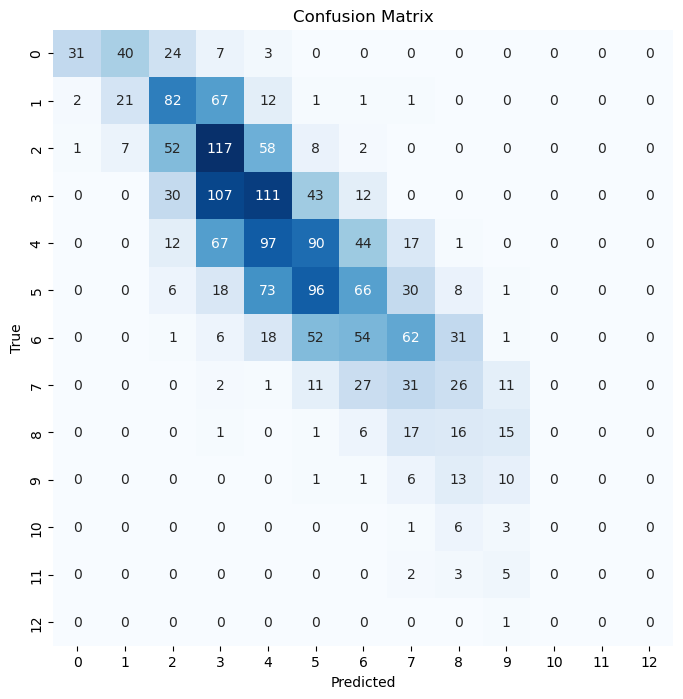

In [30]:
model, results = train_cow_counter(
    data_root=DATA_ROOT,
    output_dir=OUTPUT_DIR,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    use_xgboost=USE_XGBOOST,
    time_based_split=TIME_BASED_SPLIT,
)

In [31]:
print(f"Test MSE: {results['test_mse']:.4f}")
print(f"Test MAE: {results['test_mae']:.4f}")
print(f"Test RMSE: {results['test_rmse']:.4f}")

Test MSE: 1.8548
Test MAE: 1.0529
Test RMSE: 1.3619
